# Gradient (AD), ML and Bankruptcy prediction

***Import packages and definition of useful functions***

In [1]:
import math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

## 1. Definition of the Bankrupty prediction use case and data management

**Altman
's Z-score**

Altman (1968) came up with a simple formula known as Z-score, whose expression is:
\begin{equation*}
    Z = 0.12 X_1 + 0.14 X_2 + 0.033 X_3 + 0.006 X_4 + 0.999 X_5
\end{equation*}
where
- $X_1$ is the working capital / total assets
- $X_2$ is the retained earnings / total assets
- $X_3$ is the earnings before interest and tax / total assets
- $X_4$ is the market value of equity / total liabilities
- $X_5$ is sale / total assets

Based on the value of the score a firm is classified as bankrupt (low score) or healthy (high score).

Bankruptcy refers to a situation where firm cannot repay its debts to its creditors.

As bankruptcy is costly for company stakeholders (employees, supppliers, banks), being able to predict its likelihood is of critical importance.

Particularly important nowadays with the rise of the so-called *zombie companies*.

### 1.1 Import Data

We use [the Polish companies bankruptcy dataset](https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data).

5 datasets:
- For companies in file ``1year``, the reported status is the one observed 5 years later.
- For companies in file ``2year``, the reported status is the one observed 4 years later.
- ...
- For companies in file ``5year``, the reported status is the one observed 1 year later.
    
Potentially, we could use the 5 datasets and analyze:
- whether a firm goes bankrupt or not after some time, irrespective of the number of years.
- whether a firm goes bankrupt or not after 1, 2, ..., 5 years. This would be a multiclass classification exercice.
    
For simplicity, we will focus on a binary classification problem. Working with a single file will also make the computation faster.

**Features description of the ``2year``**, there is no header but 64 features (expressed in ratios or in local currency):

- X1 net profit / total assets
- X2 total liabilities / total assets
- X3 working capital / total assets
- X4 current assets / short-term liabilities
- X5 [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
- X6 retained earnings / total assets
- X7 EBIT / total assets
- X8 book value of equity / total liabilities
- X9 sales / total assets
- X10 equity / total assets
- X11 (gross profit + extraordinary items + financial expenses) / total assets
- X12 gross profit / short-term liabilities
- X13 (gross profit + depreciation) / sales
- X14 (gross profit + interest) / total assets
- X15 (total liabilities * 365) / (gross profit + depreciation)
- X16 (gross profit + depreciation) / total liabilities
- X17 total assets / total liabilities
- X18 gross profit / total assets
- X19 gross profit / sales
- X20 (inventory * 365) / sales
- X21 sales (n) / sales (n-1)
- X22 profit on operating activities / total assets
- X23 net profit / sales
- X24 gross profit (in 3 years) / total assets
- X25 (equity - share capital) / total assets
- X26 (net profit + depreciation) / total liabilities
- X27 profit on operating activities / financial expenses
- X28 working capital / fixed assets
- X29 logarithm of total assets
- X30 (total liabilities - cash) / sales
- X31 (gross profit + interest) / sales
- X32 (current liabilities * 365) / cost of products sold
- X33 operating expenses / short-term liabilities
- X34 operating expenses / total liabilities
- X35 profit on sales / total assets
- X36 total sales / total assets
- X37 (current assets - inventories) / long-term liabilities
- X38 constant capital / total assets
- X39 profit on sales / sales
- X40 (current assets - inventory - receivables) / short-term liabilities
- X41 total liabilities / ((profit on operating activities + depreciation) * (12/365))
- X42 profit on operating activities / sales
- X43 rotation receivables + inventory turnover in days
- X44 (receivables * 365) / sales
- X45 net profit / inventory
- X46 (current assets - inventory) / short-term liabilities
- X47 (inventory * 365) / cost of products sold
- X48 EBITDA (profit on operating activities - depreciation) / total assets
- X49 EBITDA (profit on operating activities - depreciation) / sales
- X50 current assets / total liabilities
- X51 short-term liabilities / total assets
- X52 (short-term liabilities * 365) / cost of products sold)
- X53 equity / fixed assets
- X54 constant capital / fixed assets
- X55 working capital
- X56 (sales - cost of products sold) / sales
- X57 (current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)
- X58 total costs /total sales
- X59 long-term liabilities / equity
- X60 sales / inventory
- X61 sales / receivables
- X62 (short-term liabilities *365) / sales
- X63 sales / short-term liabilities
- X64 sales / fixed assets

Finally, the dataset reports for each instance, in the last column, a label taht take on the values 0 and 1:

- Feature 65 : 0/1 = survived/went bankrupt in the next year

**Our objective is to build a model taht identifies as accurately as possible the true label. This is a supervised learning taxt as the label of each company is reported in the datasets.**

**Task 1**: import data

In [2]:
df = pd.read_csv("year2.txt", header=None, na_values=["?"])
print(df.shape)
df.head()

(10173, 65)


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0.202350,0.46500,0.240380,1.5171,-14.547,0.510690,0.25366,0.91816,1.15190,0.42695,...,0.13184,0.473950,0.86816,0.00024,8.5487,5.16550,107.740,3.38790,5.3440,0
1,0.030073,0.59563,0.186680,1.3382,-37.859,-0.000319,0.04167,0.67890,0.32356,0.40437,...,0.12146,0.074369,0.87235,0.00000,1.5264,0.63305,622.660,0.58619,1.2381,0
2,0.257860,0.29949,0.665190,3.2211,71.799,0.000000,0.31877,2.33200,1.67620,0.69841,...,0.16499,0.369210,0.81614,0.00000,4.3325,3.19850,65.215,5.59690,47.4660,0
3,0.227160,0.67850,0.042784,1.0828,-88.212,0.000000,0.28505,0.47384,1.32410,0.32150,...,0.29358,0.706570,0.78617,0.48456,5.2309,5.06750,142.460,2.56210,3.0066,0
4,0.085443,0.38039,0.359230,1.9444,21.731,0.187900,0.10823,1.37140,1.11260,0.52167,...,0.10124,0.163790,0.89876,0.00000,5.7035,4.00200,89.058,4.09840,5.9874,0


### 1.2 Missing data

Missing values are reported using ? character.

**Task 2**: Generate a barplot that displays for each feature the number of missing values

<AxesSubplot:>

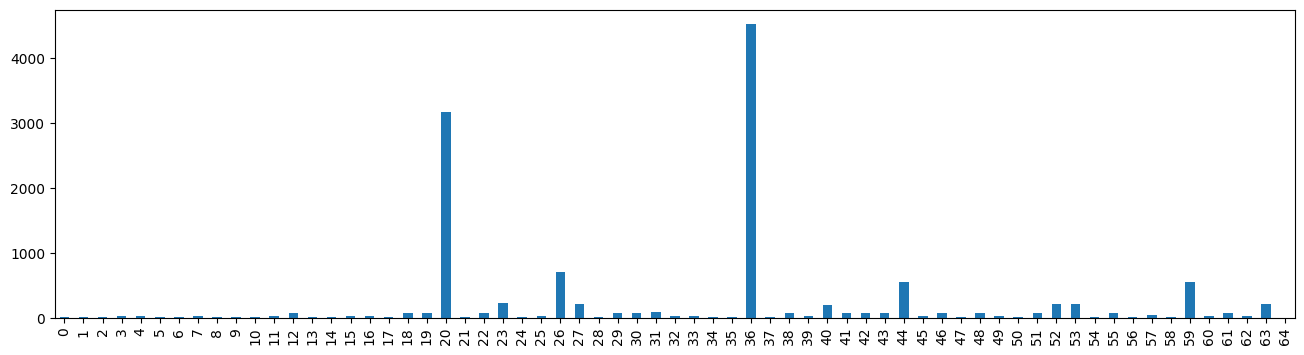

In [3]:
# insert your code here
plt.figure(figsize=(16,4))
(len(df.index)-df.count()).plot.bar()

A possible solution to handle missing values is to inpute a replacement value (e.g. mean or median of the feature)

Here, we use a simpler solution: we remove all features that contains more than 50 missing values. Once this is done, we remove all instance that still contains missing values.

**Task 3**:
- Step 1: Remove from the dataset all features that contain more than 50 missing values
- Step 2: Remove all missing values from the dataset

In [4]:
# insert your code here
df = df.drop(df.columns[df.apply(lambda col: col.isnull().sum() > 50)], axis=1)
df.dropna(inplace=True)
print(df.shape)

(10088, 38)


### 1.3 Training set and test set

Training a ML model amounts to finding the model parameter values that allow to generate the predictions that best match the actual mabels

if the model is trained using the whole dataset, we will get the optimal parameter values for the dataste, which will allow us to achieve the best in-sample predictions.

Yetn there is no guarantee on how general the model is and how it will perform out-of-sample, that is on a new mdataste, using data the model has never seen before.

For that reason, in every ML project, the original dataset is always split into 2 sets (at least):

- A train set: the dataset on which training is performed and models are fine-tuned
- A test set: the dataset containing unseen data, which is used to assess the performance of the final model

### 1.4 Differences in feature value magnitudes

ML algorithms do not perform weel in general when features greatly differ in magnitude or are expressed using different scales (here ratios and currency units)

Two standard procedure allow to transform feature so that they get all expressed in the same scale:
- Min-max scaling or normalization
- Standardization

In [5]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,47,49,50,54,56,57,58,60,62,64
count,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,...,10088.000000,10088.000000,10088.000000,1.008800e+04,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000,10088.000000
mean,0.056863,0.633485,0.080845,3.455431,-120.644258,-0.103082,0.136543,3.816087,2.849920,0.349746,...,0.082498,2.772320,0.516627,5.970039e+03,-0.039787,12.565388,3.056922,16.875062,11.188472,0.039155
std,0.679260,6.546280,6.540730,15.705346,6879.776696,6.561223,6.499309,29.361301,97.032686,6.545727,...,6.222518,13.564894,6.545366,6.571290e+04,12.293023,634.211780,239.163399,296.688387,234.530106,0.193974
min,-61.628000,0.000626,-479.960000,0.002079,-438250.000000,-508.410000,-61.628000,-1.594500,-0.000857,-479.910000,...,-9.679200,0.002079,0.000516,-1.805200e+06,-979.250000,-4.549700,-189.580000,-0.007521,-0.367890,0.000000
25%,0.000646,0.279883,0.011708,1.028650,-50.043250,0.000000,0.002411,0.393083,1.028000,0.276637,...,-0.039410,0.751385,0.196350,5.024375e+00,0.010760,0.872880,0.000000,4.724150,3.120300,0.000000
50%,0.050127,0.489650,0.188745,1.521550,-2.091050,0.000000,0.060594,0.999350,1.290600,0.489460,...,0.023420,1.189850,0.353430,8.389200e+02,0.127470,0.950005,0.005363,7.013950,5.218200,0.000000
75%,0.141700,0.705630,0.398108,2.727050,50.972750,0.075571,0.166465,2.506250,2.263450,0.700402,...,0.123122,2.146875,0.550398,4.025350e+03,0.310262,0.993390,0.250970,11.108750,9.023075,0.000000
max,7.372700,480.960000,0.996880,782.250000,70686.000000,14.756000,649.230000,1597.400000,9742.300000,0.999370,...,623.850000,544.560000,480.960000,3.657400e+06,147.190000,59672.000000,23853.000000,26862.000000,23454.000000,1.000000


When scaling is performed, the scaling parameters must be computed using the train set only to avoid any look-ahead bias.

Scaling is thus performed in three steps:

    - Step 1: compute the min and max of each feature in the train set
    - Step 2: perform feature scaling on the train set
    - Step 3: perform feature scaling on the test set using values found at step 1
    
Note that scaling is applied to features only, not labels.

In [6]:
def normalize(*arg): # df [,min_vals,max_vals]
    """ Normalizes the features of a dataframe
    Up to 3 arguments
    - 1st argument (mandatory) = df: name of dataframe to normalize
    - 2nd argument (optional): min_vals = list of min value of each feature
    - 3rd argument (optional): max_vals = list of max value of each feature
    If df only is passed, the function normalizes X_ij, i.e. ith value of feature j as:
                               (X_ij - min_j)/(max_j - min_j)                           (1)
    and returns the min_j and max_j lists
    If df, min_vals and max_vals are passed, df is normalized as per (1) using these values
    """
    df = arg[0]
    result = df.copy()
    if len(arg)==1:
        minval, maxval = [], []
        for feature_name in df.columns:
            min_value = df[feature_name].min()
            max_value = df[feature_name].max()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
            minval.append(min_value)
            maxval.append(max_value)
        return result, minval, maxval
    else:
        minvals = arg[1]
        maxvals = arg[2]
        for i in range(df.shape[1]):
            result.iloc[:,i] = (df.iloc[:,i] - minvals[i]) / (maxvals[i] - minvals[i])
        return result

###  1.5 Balancing the dataset

The issue (for ML) is that the number of surviving firms is 24 times as large as the number of dead firms: the dataset is unbalanced

If we train a ML model on an unbalanced dataset the resulting parameters will be biased towards predicting the majority class

In the extreme case where a naive model returns the prediction 0 for all instances, the predictions will be correct 96\% of the time. Yet, its out-of-sample ability to identify future bankrupt firms will be very small.

To make a model identifying the features that are useful at predicting bankruptcy, trainig must be performed on a balanced dataste

We will build a train daatset that has the same proportion of future surviving and bankrupt firms

Dataset balancing can be performed in two ways:
- Undersampling: randomly remove surviving firms on order to get the same 50\% proportion of survivig and bankrupt firms
- Oversampling:
    - Naive: randomly duplicate examples in the minority class
    - SMOTE: Synthetic Minority Oversampling TEchnique. Generate artificial examples based on k-nearest neighbours from instances in the minority class.

It is possible to combine under- and over- sampling.

We will build a train set that contains 75\% of the dead firms from the original dataset and the same number of surviving firms. Both the dead firms and the surviving firms will be randomly chosen.

**Task 4-1**: Plot a histogram that reports the number of surviving firms (label=0) and dead firms (label=1) in the **dataset**

(array([9693.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         395.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

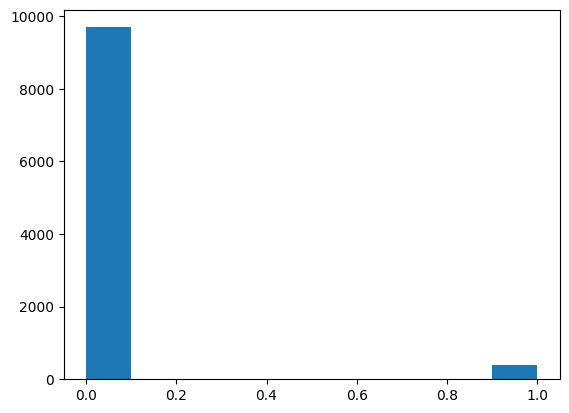

In [7]:
# insert your code here
plt.hist(df.iloc[:,-1])

**Task 4-2**:
- Generate a dataframe named `surv` that contains surviving firms, and a dataframe named `dead` that contains dead firms
- Store in variables `l_surv`and `l_dead`the number of surviving firms and dead firms, respectively

In [8]:
# insert your code here
surv, dead = df[df.iloc[:, -1]==0], df[df.iloc[:, -1]==1]
l_surv, l_dead = len(surv), len(dead)
print(l_surv, l_dead)

9693 395


**Task 5**:
- Using the `sample` function, create a `dead_train` dataframe that contains 75% of the dead firms, where those firms are ramdomly selected
- Create a `surv_train` dataframe that contains as many randomly selected surviving firms as the number of randomly selected dead firms
- Combine vertically the `dead_train` and the `surv_train` dataframes into a single dataframe names `Train`

In [9]:
np.random.seed(42) # for reproductibility of results

# insert your code here
dead_train = dead.sample(int(l_dead*.75))
surv_train = surv.sample(int(l_dead*.75))

Train = pd.concat([dead_train, surv_train], axis=0)

In [10]:
l_surv_train, l_dead_train = len(surv_train), len(dead_train)
print(l_surv_train, l_dead_train)

296 296


In [11]:
len(Train)

592

All firms not selected in the Train dataframe must now be put in the Test dataframe.

**Task 6**: 
- Create a `dead_remain` dataframe with all instances of dead firms **<u>not</u>** in the `dead_train` dataframe
- Create a `surv_remain` dataframe with all instances of surviving firms **<u>not</u>** in the `surv_train` dataframe
- Combine vertically the `dead_remain` and the `surv_remain` dataframes into a single dataframe named `Test`


In [12]:
# insert your code here
dead_remain = dead[~dead.isin(dead_train)].dropna() # observations in dead_train are reported as NaN
surv_remain = surv[~surv.isin(surv_train)].dropna()

Test = pd.concat([dead_remain, surv_remain], axis=0)

In [13]:
l_surv_remain, l_dead_remain = len(surv_remain), len(dead_remain)
print(l_surv_remain, l_dead_remain)

9397 99


The next step is to separate the labels from the features

**Task 7**: 
- Create the `Ytrain` and `Ytest` dataframes with the <u>labels</u> from the `Train` and the `Test` dataframes, respectively
- Create the `Xtrain` and `Xtest` dataframes with the <u>features</u> from the `Train` and the `Test` dataframes, respectively


In [14]:
# Extract labels
# insert your code here
Ytrain = Train.iloc[:,-1]
Ytest = Test.iloc[:,-1]

# Extract features
# insert your code here
Xtrain = Train.iloc[:,:-1] 
Xtest = Test.iloc[:,:-1]

Finally, we can normalize both the train and the test sets.

**Task 8**:
- Create the `Xtrain_norm` dataframe by applying feature scaling to the `Xtrain` dataframe
- Create the `Xtest_norm` dataframe by applying feature scaling to the `Xtest` dataframe

In [15]:
# insert your code here
Xtrain_norm, min_vals, max_vals = normalize(Xtrain)
Xtest_norm = normalize(Xtest, min_vals, max_vals)

In [16]:
Xtrain.describe()

,0,1,2,3,4,5,6,7,8,9,...,45,47,49,50,54,56,57,58,60,62
count,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,...,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000
mean,0.013282,1.440260,-0.723301,3.722466,-213.398384,-1.005629,0.025442,4.032041,1.872854,-0.459846,...,2.882442,-0.008606,3.211994,1.310033,2687.924067,-0.105317,1.839165,40.811098,17.193168,7.376815
std,0.534558,19.747443,19.735366,24.979245,6104.534815,20.981582,0.539040,34.821886,1.804231,19.744712,...,22.767715,0.448191,24.884444,19.752124,27801.568825,5.115328,20.218933,980.379744,75.118744,17.539184
min,-6.815000,0.001504,-479.960000,0.002079,-146150.000000,-508.410000,-6.815000,-0.997810,0.000000,-479.910000,...,0.000180,-7.881700,0.002079,0.001504,-259740.000000,-76.982000,0.000000,-80.147000,0.000000,0.000000
25%,-0.018667,0.345823,-0.067543,0.871020,-64.328500,-0.007887,-0.018488,0.242565,1.013975,0.195213,...,0.440908,-0.054973,0.661705,0.255537,-268.292500,0.000000,0.889915,0.000000,4.685025,2.714975
50%,0.027529,0.586305,0.114150,1.257850,-18.437000,0.000000,0.035270,0.683745,1.214700,0.400245,...,0.739520,0.010124,1.003650,0.421305,444.820000,0.087228,0.966220,0.005827,7.241400,4.347150
75%,0.112798,0.793290,0.293238,2.161025,28.649250,0.014939,0.128980,1.822100,2.328850,0.628208,...,1.405500,0.103478,1.613200,0.647305,2269.950000,0.286965,1.000775,0.323578,11.382500,7.807550
max,7.372700,480.960000,0.975730,431.120000,22876.000000,0.772020,7.372700,664.010000,22.743000,0.998500,...,421.770000,0.928760,431.120000,480.960000,537580.000000,38.355000,492.000000,23853.000000,1324.500000,376.040000


In [20]:
Xtrain_norm.describe()

,0,1,2,3,4,5,6,7,8,9,...,45,47,49,50,54,56,57,58,60,62
count,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,...,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000
mean,0.481282,0.002991,0.996467,0.008630,0.863397,0.996509,0.482139,0.007564,0.082349,0.996968,...,0.006834,0.893608,0.007446,0.002721,0.329138,0.666540,0.003738,0.005054,0.012981,0.019617
std,0.037678,0.041059,0.041035,0.057941,0.036116,0.041206,0.037993,0.052363,0.079331,0.041057,...,0.053981,0.050870,0.057721,0.041068,0.034869,0.044351,0.041095,0.040963,0.056715,0.046642
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.479030,0.000716,0.997831,0.002016,0.864279,0.998468,0.479043,0.001865,0.044584,0.998330,...,0.001045,0.888345,0.001530,0.000528,0.325430,0.667453,0.001809,0.003349,0.003537,0.007220
50%,0.482286,0.001216,0.998209,0.002913,0.864551,0.998484,0.482832,0.002529,0.053410,0.998756,...,0.001753,0.895733,0.002323,0.000873,0.326324,0.668209,0.001964,0.003349,0.005467,0.011560
75%,0.488296,0.001646,0.998581,0.005008,0.864829,0.998513,0.489437,0.004240,0.102399,0.999230,...,0.003332,0.906329,0.003737,0.001343,0.328613,0.669941,0.002034,0.003362,0.008594,0.020763
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
Xtest.describe()

,0,1,2,3,4,5,6,7,8,9,...,45,47,49,50,54,56,57,58,60,62
count,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,...,9496.000000,9496.000000,9496.000000,9496.000000,9.496000e+03,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000
mean,0.059580,0.583189,0.130977,3.438784,-114.861777,-0.046815,0.143469,3.802624,2.910833,0.400218,...,2.586799,0.088178,2.744910,0.467164,6.174652e+03,-0.035702,13.234083,0.703249,16.855230,11.426099
std,0.687204,4.605438,4.600310,14.939694,6925.480649,4.275350,6.697446,28.988943,100.010548,4.605299,...,14.118622,6.412551,12.526885,4.602961,6.736910e+04,12.606009,653.658670,29.089834,305.222767,241.689277
min,-61.628000,0.000626,-440.740000,0.002264,-438250.000000,-398.120000,-61.628000,-1.594500,-0.000857,-440.740000,...,-5.256100,-9.679200,0.002264,0.000516,-1.805200e+06,-979.250000,-4.549700,-189.580000,-0.007521,-0.367890
25%,0.000894,0.277290,0.015974,1.039300,-49.059250,0.000000,0.002899,0.409535,1.029000,0.283410,...,0.592220,-0.038386,0.759858,0.194315,1.466975e+01,0.011969,0.871975,0.000000,4.725850,3.149050
50%,0.051782,0.483060,0.193560,1.541800,-0.939565,0.000000,0.062915,1.028300,1.295700,0.495375,...,1.015050,0.024399,1.206650,0.348455,8.793950e+02,0.129680,0.948945,0.005109,7.005200,5.273050
75%,0.143402,0.698887,0.401905,2.766825,51.780500,0.080294,0.168065,2.542125,2.262225,0.704827,...,1.896000,0.123900,2.172925,0.544880,4.181975e+03,0.312032,0.993080,0.247670,11.079250,9.097200
max,7.138400,441.740000,0.996880,782.250000,70686.000000,14.756000,649.230000,1597.400000,9742.300000,0.999370,...,782.250000,623.850000,544.560000,441.740000,3.657400e+06,147.190000,59672.000000,2517.700000,26862.000000,23454.000000


In [22]:
Xtest_norm.describe()

,0,1,2,3,4,5,6,7,8,9,...,45,47,49,50,54,56,57,58,60,62
count,9496.000000,9496.000000,9496.000000,9.496000e+03,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,...,9496.000000,9496.000000,9.496000e+03,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000,9496.000000
mean,0.484545,0.001209,0.998244,7.971612e-03,0.863980,0.998392,0.490458,0.007219,0.127988,0.998756,...,0.006133,0.904593,6.362136e-03,0.000968,0.333511,0.667143,0.026899,0.003378,0.012726,0.030385
std,0.048437,0.009576,0.009565,3.465338e-02,0.040973,0.008397,0.472060,0.043592,4.397421,0.009576,...,0.033475,0.727834,2.905675e-02,0.009570,0.084494,0.109297,1.328575,0.001215,0.230444,0.642722
min,-3.863417,-0.000002,0.081549,4.281891e-07,-1.728136,0.216602,-3.863417,-0.000897,-0.000038,0.081450,...,-0.012462,-0.204019,4.281891e-07,-0.000002,-1.938318,-7.822884,-0.009247,-0.004572,-0.000006,-0.000978
25%,0.480409,0.000573,0.998004,2.405887e-03,0.864370,0.998484,0.480550,0.002116,0.045245,0.998513,...,0.001404,0.890227,1.757705e-03,0.000401,0.325785,0.667557,0.001772,0.003349,0.003568,0.008374
50%,0.483995,0.001001,0.998374,3.571461e-03,0.864654,0.998484,0.484780,0.003047,0.056971,0.998954,...,0.002406,0.897354,2.794063e-03,0.000721,0.326869,0.668577,0.001929,0.003349,0.005289,0.014023
75%,0.490453,0.001450,0.998807,6.412969e-03,0.864966,0.998641,0.492191,0.005323,0.099469,0.999389,...,0.004495,0.908647,5.035388e-03,0.001130,0.331011,0.670158,0.002018,0.003359,0.008365,0.024192
max,0.983486,0.918455,1.000044,1.814464e+00,1.282856,1.027464,46.240405,2.403578,428.364772,1.000002,...,1.854684,71.702465,1.263130e+00,0.918455,4.912883,1.943626,121.284553,0.108546,20.280861,62.371024


## 2. Optimisation and learning

Bankruptcy probability prediction

For each instance *i*, the model has to return the estimated probability $\hat{p}^{(i)}$ that the firm will go bankrupt conditional on the corresponding vector of features $x^{(i)}$.

The prediction wil be made using the logistic function. With the logistic function, conditional probabilities are computed as follows

\begin{equation}
    \left\{
    \begin{array}{ll}
        \hat{p}\left( y^{(i)} = 1 | \omega, b, x^{(i)} \right) & = \sigma\left(\omega^{T} x^i + b\right) \\
        \hat{p}\left( y^{(i)} = 0 | \omega, b, x^{(i)} \right) & = 1 - \sigma\left(\omega^{T} x^i + b\right)
    \end{array}
    \right.
\end{equation}
where:

- $x^{(i)}$ is a column vector with 37 components (number of remaining features);
- $w$ is a column vector of $n=37$ weights (coefficients);
- $b$ is a bias term (intercept/constant);
- $\sigma$ is the logistic function, i.e. $\sigma(t) = \frac{1}{\left(1+\exp(-t)\right)}$.

### 2.1 Class prediction

The prediction rule is as follows:
\begin{equation}
    \hat{y}^{(i)} = \left\{
    \begin{array}{ll}
        0 & \mbox{ if } \hat{p}^{(i)} < 0.5 \\
        1 & \mbox{ if } \hat{p}^{(i)} \geq 0.5
    \end{array}
    \right.
\end{equation}

Replacing $\hat{p}^{(i)}$ by its expression as computed using the logistic function we get the following:
<img src="Logistic-Function.png" width=50%>

### 2.2 Cost function

Training the model aims at determining the $\omega$ and $b$ values such that the model estimates a high $\hat{p}^{(i)}$ value when $y^{(i)}=1$ and a low $\hat{p}^{(i)}$ value when $y^{(i)}=0$

This is achieved by defining a cost function $F(\omega,b)$ which, for example $i$, is computed as:
\begin{equation}
    F^{(i)}(\omega,b) = \left\{
    \begin{array}{ll}
        -log(\hat{p}^{(i)}) & \mbox{ if } y^{(i)} = 1 \\
        -log(1 - \hat{p}^{(i)}) & \mbox{ if } y^{(i)} = 0
    \end{array}
    \right.
\end{equation}
For a set of $m$ instances (or a batch of size $m$), the cost expresses:
$$ F(\omega,b) = - \frac{1}{m}\sum^{m}_{i=1} y^{(i)} \log \left[ \sigma \left(\omega^T x^{(i)} + b \right) \right]+ (1 - y^{(i)}) \log \left[ 1 - \sigma \left( \omega^T x^{(i)} + b \right) \right]$$

We can check that the total cost increases with errors:

- if the model predicts a low $\hat{p}^{(i)}$ probability of bankruptcy for fimr $i$ whereas it goes bankrupt, i.e. when $y^{(i)} = 1$, $- y^{(i)}\log\left(\hat{p}^{(i)} \right)$ is large;
- if the model predicts a large $\hat{p}^{(i)}$ probability of bankruptcy for fimr $i$ whereas it survives, i.e. when $y^{(i)} = 0$, $- (1 - y^{(i)})\log \left(1 - \hat{p}^{(i)} \right)$ is large.

**Note:** the cost function is the opposite of the log-likelihood:

- Assuming indepedence observations, the likelihood of observing the sample is:
\begin{eqnarray*}
    L(\omega,b) & = & \prod^{m}_{i=1} Pr\left( Y = y^{(i)} | X = x^{(i)}\right) \\
    & = & \prod^{m}_{i=1} \sigma\left(\omega^T x^{(i)} + b \right)^{y^{(i)}} . \left(1 - \sigma\left(\omega^T x^{(i)} + b \right)\right)^{(1-y^{(i)})}  
\end{eqnarray*}
    
- Therefore the expression for the log-likelihood is
$$ LL(\omega,b) = \sum^{m}_{i=1} y^{(i)} \log \left[ \sigma \left(\omega^T x^{(i)} + b \right) \right] + (1 - y^{(i)}) \log \left[ 1 - \sigma \left( \omega^T x^{(i)} + b \right) \right]$$

***Def:*** The gradient of f: $\mathbb{R}^{n} \mapsto \mathbb{R}$ is $$\nabla f (x)=\begin{bmatrix}
\frac{\partial f}{\partial x_1} \\ 
\vdots \\
\frac{\partial f}{\partial x_n} 
\end{bmatrix} \in \mathbb{R}^{n} $$
i.e., a vector that gathers the partial derivatives of f. 

### 2.3 Compute gradient with JAX framework

In [19]:
import jax.numpy as jnp
from jax import grad

def jnp_sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

# Computes our network's output
def reg_logistic(params, x):
    w, b = params
    return jnp_sigmoid(jnp.dot(w, x) + b)

# Cross-entropy loss
def cost(params, x, y):
    out = reg_logistic(params, x)
    cross_entropy = -y * jnp.log(out) - (1 - y)*jnp.log(1 - out)
    return cross_entropy[0]

# compute loss gradient
loss_grad = grad(cost)

def prediction(params,x):
    w, b = params
    out = jnp_sigmoid(np.dot(w,x)+b)
    if out >= .5:
        return 1
    else:
        return 0

#### 2.3.2 Algorithm to find the minimal cost : Gradient Descent

<img src="Gradient_Descent.png" width=50%>

##### 2.3.2.1 Batch Gradient Descent

In batch gradient descent, parameters are updated using the full training set at every step

Gradient descent algorithm:
1. Initialize $\omega$ components and $b$ with random values
2. Iterate until convergence to minimum cost (or other stopping criterion):
    1. For all $j \in [1,n]: \omega_j := w_j - \eta \frac{\partial}{\partial \omega_j} J(\omega,b)$
    2. $b := b -\eta \frac{\partial}{\partial b} J(\omega,b)$
where $\eta$ is call the learning rate. It determines the size of the downhill step

As $\eta$ is at the discretion of the modeler, it is a hyperparameter of the model:
- If it is too small, convergence will be slow and potentiall will not be reached;
- If it is too high, the parameter values may bounce around their 'true' value and potentially the algorithm may diverge.

<img src="Batch_Gradient_Descent.png" width=70%>

The number of iterations is another parameter that is at the discretion of the modeler
- If the number of iterations is too low, the model will not have enough steps to reach the minimul cost;
- If it is too high, there will ne unneccessary steps when the gradient value is near 0.

In [ ]:
eta = 0.01
loss_list=[]
np.random.seed(42)
# random initialization of w and b
w = np.random.uniform(low=-1, high=1, size=Xtrain_norm.shape[1]) 
b = np.random.uniform(low=-1, high=1, size=1)
params=[w,b]
for epoch in range(100):
    # Shuffle randomly Xtrain_norm
    Xtrain_rand = Xtrain_norm.sample(frac=1)
    # Reorder Ytrain in the same order as Xtrain_rand
    Ytrain_rand = Ytrain.reindex(Xtrain_rand.index)
    for i in range(Xtrain_rand.shape[0]):
        x = Xtrain_rand.iloc[i,:]
        y = Ytrain_rand.iloc[i]
        grad_w = loss_grad(params, jnp.array(x), jnp.array(y))[0]
        grad_b =  loss_grad(params, jnp.array(x), jnp.array(y))[1]
        w -=eta * grad_w
        b -=eta * grad_b
        params=[w,b]
    loss = 0
    for i in range(Xtrain_rand.shape[0]):
        x = Xtrain_rand.iloc[i,:]
        y = Ytrain_rand.iloc[i]
        loss += cost(params,jnp.array(x),jnp.array(y))
    loss = loss / Xtrain_rand.shape[0]
    loss_list.append(loss)
    if epoch % 10 == 0:
        print("loss epoch", epoch, ":", loss)
print("loss epoch", epoch, ":", loss)
print("\nfinished\n")

loss epoch 0 : 0.6947355
loss epoch 10 : 0.6913588
loss epoch 20 : 0.68982583
loss epoch 30 : 0.7279116
loss epoch 40 : 0.70077795


Evolution of loss (cost) through epochs

In [ ]:
epoch = np.arange(len(loss_list))
plt.plot(epoch, loss_list)

**Accuracy**

Accuracy (on the train set) corresponds to the ratio of correct predictions divided by the number of instances.

**Task 10**: Code the computation of the accuracy on the train set.

In [ ]:
count_ok = 0
for i in range(Xtrain_norm.shape[0]):
        x = Xtrain_norm.iloc[i,:]
        y = Ytrain.iloc[i]
        params=[w,b]
        if prediction(params,x) == y:
            count_ok += 1
print("accuracy:{:.2f}%".format(100 * count_ok/Xtrain_norm.shape[0]))

Weights ($\omega$)

<AxesSubplot:>

<Figure size 1600x400 with 0 Axes>

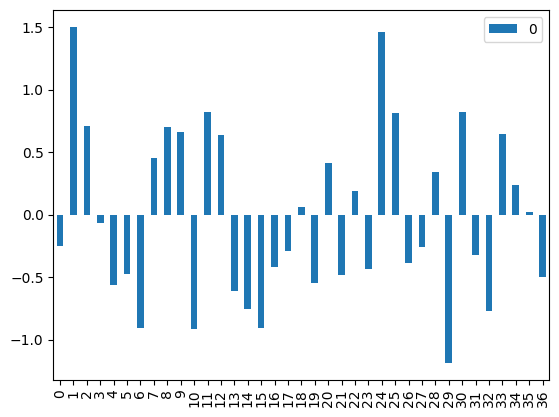

In [95]:
plt.figure(figsize=(16,4))
w=pd.DataFrame(w)
w.plot.bar()

In [79]:
# vectorized version of prediction accuracy
def accuracy(X, Y, w, b):
    pred = (jnp_sigmoid(np.dot(X, w)+b)>=0.5)
    check = (pred==Y)
    return check.sum()/len(pred)

In [73]:
print("accuracy: {:.2f}%".format(100 * accuracy(Xtrain_norm, Ytrain, w, b)))

accuracy: 52.36%


## 3. How good is our model?

In [74]:
# insert your code here
print("accuracy:{:.2f}%".format(100 * accuracy(Xtest_norm, Ytest, w, b)))

accuracy:93.24%


## 4. Save train and test non-normalized datasets

In [39]:
trainset = pd.concat([Xtrain, Ytrain], axis = 1)
testset = pd.concat([Xtest, Ytest], axis = 1)
trainset.to_csv("trainset_2.csv", header=True, index=False)
testset.to_csv("testset_2.csv", header=True, index=False)